# Person Segmentation Netowork Using Fast-SCNN

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [1]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import sys
sys.path.append("..")
from seg_net.data import *
from seg_net.fast_scnn import fast_scnn
from data import *
import keras

Using TensorFlow backend.


## Set Model Params

In [11]:
INPUT_SHAPE = (768, 768, 3) #(768,768,3) (512,512,3)
NUM_CLASS = 1
BACKBONE = 'fast'
MODEL_NAME = 'scnn'
LOSS_METRICS = 'BCE_ACC_IOU'
MODEL_PATH = '/media/new_hdd2/seg_net/results/Models/Models'
ACTIVATION = 'sigmoid'

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0])
keras_filename = '{}.hdf5'.format(model_fname)

## Build Model

In [3]:
model = fast_scnn(input_shape = INPUT_SHAPE, num_classes = 1, activation = 'sigmoid')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.001)   
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 384, 384, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
separable_

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [12]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(1,'../data/raw/train','images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm="divide" , 
                        binary = False,
                        num_class = NUM_CLASS, 
                        multiclass = False)

'''valGene = validationGenerator(1,'../data/raw/val','images','annotations',
                                save_to_dir = None,
                                target_size = INPUT_SHAPE[:2],
                                imgNorm="divide" , 
                                binary = False,
                                num_class = NUM_CLASS, 
                                multiclass = False)'''

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                       monitor='loss',
                                                       verbose=1, 
                                                       save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

Found 1603 images belonging to 1 classes.
Found 1603 images belonging to 1 classes.


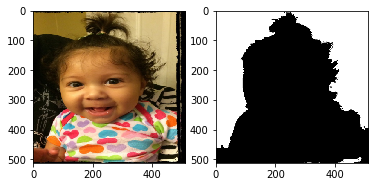

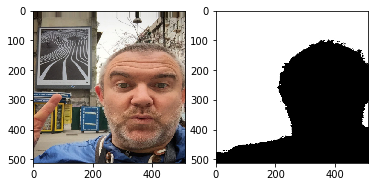

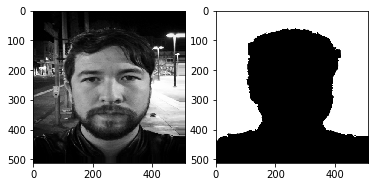

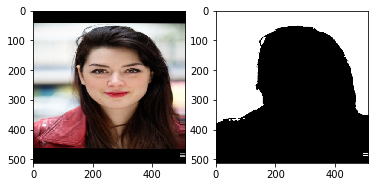

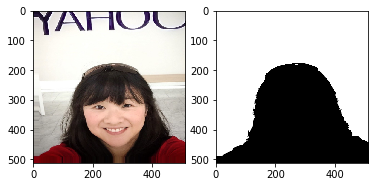

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(5):
    inp,otp = next(myGene)
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(inp[0,:,:,:])
    #axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [ ]:
model.fit_generator(myGene,steps_per_epoch=3000,epochs=5,
                    #validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=0)

Epoch 1/5
Found 1603 images belonging to 1 classes.
Found 1603 images belonging to 1 classes.
 819/3000 [=======>......................] - ETA: 36:33 - loss: 0.5586 - acc: 0.6624

## Test Model

In [ ]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    img_ = preprocess_input(img_, imgNorm="divide")
    images.append(img)
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    outs.append(np.squeeze(model.predict(img_)))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

In [ ]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #im[mask<0.3]=0
    #im[mask==0]=0
    im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

In [ ]:
import random
i = random.choice(range(0,22))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
#mask = cv2.resize(outs[i],im.shape[:2])
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [15,15]
plt.imshow(im)